# Replication code for Efficient Concentration with Gaussian Approximation

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from math import sqrt, exp, log, asin, acos, inf
import math
from scipy.optimize import minimize_scalar
from scipy.stats import norm, kstwo
from scipy.special import gammaln, hyp2f1, erfi, gammaincc, gamma
from scipy.integrate import quad
from ttictoc import tic,toc
import os

%matplotlib inline
from matplotlib import pyplot as plt 
plt.rcParams['text.usetex'] = True

from functools import partial
import pickle

## Helper functions

In [2]:
def savefig(fig, file_name, fig_dir="figs"):
    """Saves figure into specified file inside of fig_dir inside"""
    os.makedirs(fig_dir, exist_ok=True)
    # Trim whitespace around the image
    fig.savefig(os.path.join(fig_dir, file_name),bbox_inches='tight',pad_inches = 0.05)

#
# Standard quantile bounds
#
def asymptotic_quantile(delta, sig=1, two_sided=True):
    """Returns asymptotic Gaussian two-sided or one-sided quantile"""
    return sig * norm.ppf(min(1,(1-delta/2) if two_sided else (1-delta)))

def bernstein_quantile(delta, n, sig=1, R=1, two_sided=True):
    """Returns Bernstein two-sided or one-sided quantile bound"""
    # Source: Theorem 2.10 of Boucheron, Lugosi, and Massart. 
    # "Concentration Inequalities A Nonasymptotic Theory of Independence"
    log_delta_term = log(2/delta) if two_sided else log(1/delta)
    return (R/3 * log_delta_term / sqrt(n) ) + sig * sqrt( 2 * log_delta_term ) 

def hoeffding_quantile(delta, R=1, two_sided=True):
    """Returns Hoeffding two-sided or one-sided quantile bound"""
    log_delta_term = log(2/delta) if two_sided else log(1/delta)
    return R * sqrt(2 * log_delta_term)

def berry_esseen_penalty(n, sig=1, R=1, two_sided=True):
    """Returns Berry-Esseen bound on the uniform distance between the standard 
    normal distribution function and the distribution function of the normalized 
    sum of an arbitrary n iid random variables with zero mean, variance sig^2, 
    and bounded by R"""
    # Source: Shevtsova, Irina (2011). "On the absolute constants in the 
    # Berry Esseen type inequalities for identically distributed summands"
    R_over_sig = R/sig
    penalty = min(.3328 * ( R_over_sig + .429 ), 
                  .33554 * ( R_over_sig + .415 )) / sqrt(n)
    return 2*penalty if two_sided else penalty

def berry_esseen_quantile(delta, n, sig=1, R=1, two_sided=True):
    """Returns Berry-Esseen two-sided or one-sided quantile bound"""
    return asymptotic_quantile(
        max(0, delta - berry_esseen_penalty(n, sig=sig, R=R, two_sided=two_sided)), 
        sig=sig, two_sided=two_sided)

def emp_bernstein_quantile(delta, n, sighat=1, R=1, two_sided=True):
    """Returns empirical Bernstein two-sided or one-sided quantile bound"""
    # Source: Thm. 4 of Maurer and Pontil, 
    # "Empirical Bernstein Bounds and Sample Variance Penalization"
    # Thm. 4 operates on [0,1] so need to multiply boundedness term by 2R
    log_delta_term = log(4/delta) if two_sided else log(2/delta)
    return ( (14*R/3 * log_delta_term * sqrt(n) / (n-1) ) + 
            sighat * sqrt( 2 * log_delta_term * n/(n-1) ) )

#
# Standard tail bounds
#
def asymptotic_tail(t, sig=1, two_sided=True):
    delta = norm.sf(t/sig)
    if two_sided: delta *= 2
    return delta

def hoeffding_tail(t, R=1, two_sided=True):
    delta = exp( - ((t/R)**2) / 2 )
    if two_sided: delta *= 2
    return delta

def bernstein_tail(t, n, sig=1, R=1, two_sided=True):
    delta = exp( - (t**2) / 2 / ((sig ** 2) + R * t / 3 / sqrt(n)) )
    if two_sided: delta *= 2
    return delta

def berry_esseen_tail(t, n, sig=1, R=1, two_sided=True):
    return (asymptotic_tail(t, sig=1, two_sided=two_sided) + 
            berry_esseen_penalty(n, sig=sig, R=R, two_sided=two_sided))

def nonuniform_berry_esseen_tail(t, n, sig=1, R=1, two_sided=True):
    # Source: Shevtsova, Irina (2017). "On the absolute constants in 
    # Nagaev–Bikelis-type inequalities."
    delta = norm.sf(t/sig) + R/sig * 17.36 / ( sqrt(n) * ((1+t/sig)**3) )
    if two_sided: delta *= 2
    return delta

## Wasserstein distance bound

In [3]:
pi = math.pi
euler = math.e
def gsn_wass(n, p, sig=1, R=1, verbose=False):
    """Bound on Lp Wasserstein distance between an iid sum and a Gaussian 
    with matching mean and variance
    
    Returns bound on the Lp Wasserstein distance between a zero mean Gaussian 
    distribution with variance sig^2 and any sum 
    S = sqrt(n) (1/n) sum_{i=1}^n Y_i with each independent and identically
    distributed Y_i having mean zero, variance = sig^2, and |Y_i| <=  R.
    
    Args:
      n - Number of datapoints X_i
      p - Wasserstein distance power >= 2
      sig - Standard deviation parameter
      R - Boundedness parameter
      verbose - If True will display minimize_scalar convergence messages
    """
    
    if p == 1:
        # Source: Corollary 4.2 of Chen, L. H. Y., Goldstein, L. and 
        # Shao, Q.–M. "Normal Approximation by Stein’s Method."
        return R / sqrt(n)
    
    # Precompute bound coefficients
    p_minus_1 = p-1
    Rtilde = R / sig
    Rtilde_sqd = Rtilde * Rtilde
    c_M = Rtilde_sqd / n
    
    c_Mtilde = 1 / n
    
    sqrt_p_minus_1 = sqrt(p_minus_1)
    sig_sqrt_p_minus_1 = sig * sqrt_p_minus_1

    one_over_p = 1/p
    n_to_1_over_p = n ** one_over_p
    sqrt_n = sqrt(n)
    
    p_plus_2 = p+2
    A = sqrt(p_plus_2 * euler / 2) * ( (2 * euler) ** one_over_p )
    two_sqrt_n = 2 * sqrt_n
    Rtilde_to_2_over_p = Rtilde**(2/p)
    Atilde = p_plus_2 * n_to_1_over_p / two_sqrt_n / Rtilde_to_2_over_p
    Astar = Rtilde_to_2_over_p * Atilde
    Utilde = (A + Rtilde * Atilde)
    U = (Astar + A) 
    
    r1a = sig * Rtilde_to_2_over_p * sqrt_n * Atilde / n_to_1_over_p
    
    r1b = sig * A
    
    r1c = sig * Utilde
    
    r1d = sig * sqrt_n * U / 2
    
    c1a = sig_sqrt_p_minus_1 * sqrt_n / n_to_1_over_p
    
    c1b = sig_sqrt_p_minus_1 * Rtilde / Rtilde_to_2_over_p
    
    c1c = sig_sqrt_p_minus_1 * sqrt_n / 2
    
    h2 = Rtilde_sqd / Rtilde_to_2_over_p - 1
    h3 = Rtilde_sqd * Rtilde / Rtilde_to_2_over_p - 1
    r2a = (sig_sqrt_p_minus_1 * Atilde / sqrt_n * 
           ( Rtilde * (1 + U / two_sqrt_n )
           + ( U/2 + p * Astar / 2 / p_minus_1 * h2 
              + Astar * p / 2 / (3*p-2) * h3   
              + A * (Rtilde - 1)
              + A * h2 / 4 ) / sqrt_n))
    
    c2a = (sig_sqrt_p_minus_1 / sqrt_n * 
           ( Rtilde * (1 + sqrt_p_minus_1 / two_sqrt_n )
           + ( p/2/sqrt_p_minus_1 * h2 
              + sqrt_p_minus_1 * p / 2 / (3*p-2) * h3   ) / sqrt_n) )
    
    n_sqd = n**2
    c2b = sig * p_minus_1 / n_sqd / 2
    
    h1 = Rtilde - 1
    r3a = sqrt_p_minus_1 / two_sqrt_n * (h2 * Astar + h1 * A)

    c3a = p_minus_1 / two_sqrt_n * h2
    
    sqrt_e = sqrt(euler)
    common_4 = sig * 2 * sqrt_e / 3 
    
    r4a = common_4 * sqrt_n * Astar / n_to_1_over_p
    
    r4b = common_4 * sqrt_n * (Astar + A)
    
    r4c = common_4 * Rtilde_sqd * Utilde / n
    
    r4d = common_4 * A

    c4a = common_4 * sqrt_p_minus_1 * sqrt_n / n_to_1_over_p
    
    c4b = common_4 * sqrt_p_minus_1 * sqrt_n
    
    c4c = (common_4 * sqrt_p_minus_1 * Rtilde * 
           Rtilde_sqd / Rtilde_to_2_over_p / n)
    
    sqrt_e_over_3 = sqrt(euler/3)
    common_5 = sig * sqrt_e_over_3 * sqrt_p_minus_1

    r5a = common_5 * sqrt_n * (U + sqrt_n)
    
    r5b = common_5 * A
    
    r5c = common_5
    
    r5d = common_5 * sqrt_n * Astar / n_to_1_over_p
    
    r5e = common_5 * Rtilde_sqd * (sqrt_n + Rtilde * Utilde) / n / sqrt_n
    
    c5a = common_5 * Rtilde_sqd * (sqrt_p_minus_1 * Rtilde_sqd / 
                                   Rtilde_to_2_over_p + sqrt_n) / n / sqrt_n
    
    c5b = common_5 * sqrt_p_minus_1 * sqrt_n / n_to_1_over_p
    
    c5c = common_5 * sqrt_n * (sqrt_p_minus_1 + sqrt_n)
 
    c5d = common_5 
    
    # Define collection of bounds on p-Wasserstein distance parameterized by k
    one_minus_1_over_p = 1 - one_over_p
    half_minus_1_over_p = one_minus_1_over_p - .5
    sqrt_pi_over_2 = sqrt(pi)/2
    Rtilde_over_sqrt_n = Rtilde / sqrt_n    
    p_minus_1_times_2 = 2 * p_minus_1
    def Gamma_diff(a, b=p_minus_1_times_2, c=c_M, d=c_Mtilde):
        # Returns (Γ(1 + a, b d) - Γ(1 + a, b c)) / (b)^(1+a) 
        # where Γ is the unregularized upper incomplete gamma function
        # and gammaincc is the regularized upper incomplete gamma function
        return gamma(1+a)*(gammaincc(1+a, d*b)-gammaincc(1+a, c*b)) / b**(1+a)
    def power_diff1(a, b=p_minus_1_times_2, c=c_M, d=c_Mtilde):
        return (c**(1+a) - d**(1+a))*b/(1+a)
    def power_diff2(a, b=p_minus_1_times_2, c=c_M, d=c_Mtilde):
        return (c**(1+a) * ( 1/(1+a) - b * c / (a + 2) ) - 
                d**(1+a) * (1/(1+a) -  b * d / (a + 2) ))
    Gamma_diff_half = Gamma_diff(.5, c=c_Mtilde, d=0)
    power_diff1_half = power_diff1(.5, c=c_Mtilde, d=0)
    power_diff2_half = power_diff2(.5, c=c_Mtilde, d=0)
    Gamma_diff_half_minus_1_over_p = Gamma_diff(half_minus_1_over_p) 
    power_diff1_half_minus_1_over_p = power_diff1(half_minus_1_over_p) 
    power_diff2_half_minus_1_over_p = power_diff2(half_minus_1_over_p) 
    Gamma_diff_minus_half = Gamma_diff(-.5)
    power_diff1_minus_half = power_diff1(-.5)
    power_diff2_minus_half = power_diff2(-.5)
    def bound(k):
        #print(k)
        # Bound is only finite for k > c_M
        if k <= c_M: 
            return inf
        
        # M represents M_{n,k} = sqrt(1-R^2/(n sig^2 k))
        M_sqd = 1 - c_M / k
        M = sqrt(M_sqd)
        # Represents 2F1(1/2, 1/p - 1/2, 3/2, M^2)
        F_pinv_minus_2inv = hyp2f1(.5, one_over_p - .5, 1.5, M_sqd)
        one_minus_M = 1-M
        
        # Mtilde represents Mtilde_{n,k} = sqrt(1-1/(n k))
        Mtilde_sqd = 1 - c_Mtilde / k
        Mtilde = sqrt(Mtilde_sqd)
        # Represents 2F1(1/2, 1/p - 1/2, 3/2, Mtilde^2)
        Ftilde_pinv_minus_2inv = hyp2f1(.5, one_over_p - .5, 1.5, Mtilde_sqd)
        sqrt_k = sqrt(k)
        arccos_Mtilde = acos(Mtilde)
        arccos_Mtilde_diff = arccos_Mtilde - Mtilde / sqrt_n / sqrt_k
        Mtilde_minus_M = Mtilde - M

        k_to_one_minus_1_over_p = k ** one_minus_1_over_p
        sqrt_k_to_one_minus_two_over_p = k_to_one_minus_1_over_p / sqrt_k
        # sqrt(k)^{1-2/p} * M * 2F1(1/2, 1/p - 1/2, 3/2, M^2)
        F_combo1 = sqrt_k_to_one_minus_two_over_p * (
            Mtilde * Ftilde_pinv_minus_2inv - M * F_pinv_minus_2inv)
       
        # The terms below correspond to the terms in the Wasserstein bound
        # omega_p^{R, kappa}       
        r1_bound = (r1a * F_combo1 + r1b * Mtilde_minus_M +
                    r1c * one_minus_M + r1d * sqrt_k * arccos_Mtilde_diff)
        c1_bound = (c1a * F_combo1 + c1b * one_minus_M + 
                    c1c * sqrt_k * arccos_Mtilde_diff)
        
        r2_bound = r2a / sqrt_k
        c2_bound = c2a / sqrt_k + c2b / k

        term_3 = (1 - Rtilde_over_sqrt_n / sqrt_k)
        c3_bound = c3a * term_3
        r3_bound = r3a * term_3
        
        # Integrate integrands of the form (1-x^2)^{power} g_1(x,k,p) 
        # for g_1(x,k,p) = exp(2(p-1)x^2 k) - 1
        C = k * p_minus_1
        two_C = 2*C
        sqrt_two_C = sqrt(2*C)
        # Closed-form g1 integral with power = 0, from M to Mtilde
        int_g1 = (sqrt_pi_over_2 * (erfi(Mtilde * sqrt_two_C) - 
                                    erfi(M * sqrt_two_C)) / sqrt_two_C
                  - Mtilde_minus_M)
        # g1 integral with power = 1/2 - 1/p
        def g1_half_minus_1_over_p(x):
            x_sqd = x**2
            return ((1-x_sqd)**half_minus_1_over_p) * (exp(two_C * x_sqd)-1)
        int_g1_half_minus_1_over_p = (
            quad(g1_half_minus_1_over_p, M, Mtilde)[0] if p != 2 else int_g1)
        combo_g1_half_minus_1_over_p = (
            sqrt_k_to_one_minus_two_over_p * int_g1_half_minus_1_over_p)
        # g1 integral with power = 1/2
        def g1_half(x):
            x_sqd = x**2
            return (sqrt(1-x_sqd)) * (exp(two_C * x_sqd)-1)
        int_g1_half = quad(g1_half, Mtilde, 1)[0]
        combo_g1_half = sqrt_k * int_g1_half
        # g1 integral with power = -1
        def g1_minus_one(x):
            x_sqd = x**2
            return (exp(two_C * x_sqd)-1)/(1-x_sqd) 
        int_g1_minus_one = quad(g1_minus_one, 0, M)[0]
        combo_g1_minus_one = int_g1_minus_one / k
        r4_bound = (r4a * combo_g1_half_minus_1_over_p 
                    + r4b * combo_g1_half + r4c * combo_g1_minus_one 
                    + r4d * int_g1)
        c4_bound = (c4a * combo_g1_half_minus_1_over_p 
                    + c4b * combo_g1_half + c4c * combo_g1_minus_one)
        
        # Integrate integrands of the form (1-x)^{power} g_2(x,k,p) 
        # for g_2(x,k,p) = exp(2(p-1)x k) - 1 - 2(p-1)x k
        # Closed-form g2 integral with power = 0, from M_sqd to Mtilde_sqd
        int_g2 = ( (exp(two_C*Mtilde_sqd) - exp(two_C*M_sqd)) / two_C 
                  - (Mtilde_sqd-M_sqd) - C * ((Mtilde_sqd**2) - (M_sqd**2)) )
        # Closed-form g2 integral with power = 1/2 - 1/p
        exp_two_C = exp(two_C)
        exp_two_C_over_sqrt_k = exp_two_C / sqrt_k
        combo_g2_half_minus_1_over_p = (
            exp_two_C_over_sqrt_k * Gamma_diff_half_minus_1_over_p
            - power_diff1_half_minus_1_over_p * sqrt_k
            - power_diff2_half_minus_1_over_p / sqrt_k)
        # Closed-form g2 integral with power = 1/2
        combo_g2_half = (
            exp_two_C_over_sqrt_k * Gamma_diff_half
            - power_diff1_half * sqrt_k
            - power_diff2_half / sqrt_k)
        # Closed-form g2 integral with power = -1/2
        int_g2_minus_half = (
            exp_two_C_over_sqrt_k * Gamma_diff_minus_half
            - power_diff1_minus_half * sqrt_k
            - power_diff2_minus_half / sqrt_k)
        # Closed-form g2 integral with power = -3/2, from 0 to M_sqd
        # Compute Gamma_diff(-1.5, c=c_M, d=k) directly using the identity
        # Γ(1/2,z) = -(1/2) Γ(-1/2, z) + exp(-z)/sqrt(z) as gammaincc does not
        # support negative arguments
        Gamma_diff_minus_3_halves = 2 * (
            p_minus_1_times_2 * Gamma_diff(-.5, c=c_M, d=k) 
            + exp(-p_minus_1_times_2* c_M)/sqrt(c_M)
            -1/k/exp_two_C_over_sqrt_k )
        power_diff1_minus_3_halves = power_diff1(-1.5, c=k, d=c_M)
        power_diff2_minus_3_halves = power_diff2(-1.5, c=k, d=c_M)
        combo_g2_minus_3_halves = (
            exp_two_C_over_sqrt_k * Gamma_diff_minus_3_halves
            - power_diff1_minus_3_halves * sqrt_k
            - power_diff2_minus_3_halves / sqrt_k)
        r5_bound = (r5a * combo_g2_half
                    + r5b * sqrt_k * int_g2 + r5c * int_g2_minus_half
                    + r5d * combo_g2_half_minus_1_over_p
                    + r5e * combo_g2_minus_3_halves)
        c5_bound = (c5a *  combo_g2_minus_3_halves 
                    + c5b * combo_g2_half_minus_1_over_p 
                    + c5c * combo_g2_half
                    + c5d * int_g2_minus_half)
        if verbose:
            print(f"bound(k={k:g}) = min({c1_bound:.2g}, {r1_bound:.2g})" 
                  f" + min({c2_bound:.2g}, {r2_bound:.2g})"
                  f" + min({c3_bound:.2g}, {r3_bound:.2g})"
                  f" + min({c4_bound:.2g}, {r4_bound:.2g})"
                  f" + min({c5_bound:.2g}, {r5_bound:.2g})")
        return (min(c1_bound, r1_bound)
                + 
                min(c2_bound, r2_bound)
                + 
                min(c3_bound, r3_bound)
                + 
                min(c4_bound, r4_bound)
                +
                min(c5_bound, r5_bound))
    
    # Alternative triangle inequality upper bound:
    # Moreover E[|S-G|^p]^{1/p} <= E[|S|^p]^{1/p} + E[|G|^p]^{1/p} 
    # <= sqrt(p-1) E[|Y_1|^p]^{1/p} + E[|G|^p]^{1/p}  (by the Marcinkiewicz-Zygmund inequality)
    # <= sqrt(p-1) E[ R^{p-2} |Y_1|^2]^{1/p} + E[|G|^p]^{1/p} 
    # <= sqrt(p-1) R * (sig/R)^{2/p} + E[|G|^p]^{1/p} 
    # = sqrt(p-1) R * (sig/R)^{2/p} + sig sqrt(2) ( Gamma((p+1)/2)/sqrt(pi) )^{1/p}
    # = sqrt(p-1) R * (sig/R)^{2/p} + sig sqrt(2) exp( [log( Gamma((p+1)/2) ) - log(pi)/2] / p )
    # = sqrt(p-1) R / Rtilde^{2/p} + sig sqrt(2) exp( [log( Gamma((p+1)/2) ) - log(pi)/2] / p )
    triangle_bound = (sqrt_p_minus_1 * R / Rtilde_to_2_over_p
                      + sig * sqrt(2) * exp( (gammaln((p+1)/2) - log(pi)/2) / p ))
    if verbose:
        print(f"triangle bound: {triangle_bound}")
    
    # Note that we must have k > c_M to ensure M is well defined and finite
    # It also suffices to consider k < k0, as otherwise 
    # the gsn_wass bound exceeds the triangle bound
    # Solve depressed quartic equation for sqrt(k_0) with coefficients
    # a_4 * sqrt(k_0)**4 + a_3 * sqrt(k_0)**3 + ... + a_1*sqrt(k_0) + a_0
    triangle_bound_ratio = triangle_bound / min(r5a, c5c)
    p_minus_1_sqd = p_minus_1**2
    roots_coeff =  (c_Mtilde**(3/2))*4*p_minus_1_sqd
    a_4 = 35 * roots_coeff
    a_3 = 0 
    a_2 = -42 * c_Mtilde * roots_coeff
    a_1 = -105 * triangle_bound_ratio
    a_0 = 15 * (c_Mtilde**2) * roots_coeff
    #print([a_4,a_3,a_2,a_1,a_0])
    roots = np.roots(np.array([a_4,a_3,a_2,a_1,a_0]))
    #print(roots)
    #print(roots[np.isreal(roots)])
    sqrt_k_0 = max(roots[np.isreal(roots)]).real
    k_0 = sqrt_k_0**2
    # If bound(k) is always less than triangle bound, return triangle bound
    if k_0 <= c_M:
        return triangle_bound
    # Moreover, we can refine this upper bound 
    k_max_term1 = sqrt_k_0 / Gamma_diff_half
    k_max_term2 = (power_diff1_half_minus_1_over_p * sqrt_k_0
                + power_diff2_half_minus_1_over_p / sqrt_k_0)
    k_max = min(k_0,log(k_max_term1 * (triangle_bound_ratio + k_max_term2)) / 2 / p_minus_1)
    if verbose:
        print(f"k range: ({c_M}, {k_max}] based on k_0 = {k_0}")
    
    # If bound(k) is always less than triangle bound, return triangle bound
    if k_max <= c_M:
        return triangle_bound
    
    if verbose:
        # Plot log bound as a function of k
        ks = np.geomspace(c_M, k_max)
        plt.plot(ks, [log(bound(k)) for k in ks])
        plt.ylabel(r'Log bound on p-Wasserstein distance') 
        plt.xlabel(r'$k$')
        plt.title(f'n = {n}, p = {p}, sig = {sig}, R = {R}')
        plt.tight_layout()
        plt.show()
    
    # Find minimal value of bound(k) over [c_M, k_max]
    minimum = minimize_scalar(bound, bounds=[c_M, k_max], 
                              method='bounded', options={"disp":verbose})
    if verbose:
        print(minimum)
    return min(triangle_bound, minimum.fun)

## Quantile bound

In [4]:
def quantile_bound(delta, n, p=None, sig=1, R=1, two_sided=True, verbose=False, Ws=None):
    """Quantile bound for an iid sum
    
    Returns q s.t. P(|S| >= q) <= delta (if two_sided) or P(S >= q) <= delta (otherwise)
    for any sum S = sqrt(n) (1/n) sum_{i=1}^n Y_i 
    with each independent and identically distributed Y_i having mean zero, 
    variance = sig^2, and |Y_i| <=  R.
    
    Specifically, returns, if p is None,
      q = min( inf_{a in (0, delta), p >= 1} q_{a,p}, q_{Bernstein} )
    or, if p is not None,
      q = min( inf_{a in (0, delta)} q_{a,p}, q_{Bernstein} )
    where, if not two_sided,
      q_{a,p} = gsn_wass(n, p, sig, R)(1/a - 1)^{1/p} + sig GsnInvCDF(1-(delta-a)),
      GsnInvCDF(s) satisfies P(Z <= GsnInvCDF(s)) = s for Z a standard Gaussian,
      and q_{Bernstein} = (R/3) log(1/delta) / sqrt_n  + sig sqrt( 2 log(1/delta) ),
    and, if two_sided,
      q_{a,p} = gsn_wass(n, p, sig, R)/a^{1/p} + sig GsnInvCDF(1-(delta-a)/2)
      and q_{Bernstein} = (R/3) log(2/delta) / sqrt_n  + sig sqrt( 2 log(2/delta) ),
    
    Args:
      delta - Upper tail probability
      n - Number of datapoints Y_i
      p - None (to return minimum bound over all p) or integer Wasserstein distance power >= 1
      sig - Standard deviation parameter
      R - Boundedness parameter
      two_sided - Provide two-sided quantile bound?
      verbose - If True will display minimize_scalar convergence messages
      Ws - If not None, this dictionary, indexed by p, will be queried for precomputed values before
        computing any gsn_wass(n, p, sig, R) values; if not present, values will 
        be added to this dictionary
    """
    if Ws is None:
        # Initialize empty dictionary
        Ws = {}
    
    # Compute minimum bound over desired range of p values
    if p is None:
        # Consider all p values >= 1
        min_over_p = True
        p_init = 1
    else:
        min_over_p = False
        p_init = p
            
    # Define collection of bounds parameterized by a in (0,delta)
    def bound(a, verbose=verbose):
        # Bound is only finite for a in (0,delta)
        if a <= 0 or a >= delta: 
            return inf
        
        p = p_init
        a_term = 1/a
        min_wass_term = inf
        while True:
            # Look up the p-Wasserstein distance between sum S and Gaussian with matching mean and variance
            if p not in Ws:
                Ws[p] = gsn_wass(n, p, sig=sig, R=R)
            if not two_sided and (p == 2):
                # Use Cantelli's inequality
                wass_term = Ws[p] * ((a_term-1) ** (1/p))
            else:
                # Use Chebyshev's inequality
                wass_term = Ws[p] * (a_term ** (1/p))
            min_wass_term = min(min_wass_term, wass_term)
            
            # Terminate if only a single p value was requested or bound for the most recent p
            # was greater than prior bound
            if (not min_over_p or wass_term > min_wass_term):
                break
                
            # Otherwise, consider the next value of p
            p += 1 

        gsn_term = asymptotic_quantile(delta-a, sig=sig, two_sided=two_sided)
        bound_val = min_wass_term + gsn_term
        if verbose:
            print(f"a={a}: bound={bound_val}, wass={min_wass_term}, gsn={gsn_term}, p_last={p}")
        return bound_val
    
            
    if verbose:
        # Plot log bound as a function of a
        a_vals = np.linspace(0, delta)
        plt.plot(a_vals, [log(bound(a,verbose=False)) for a in a_vals])
        plt.ylabel(r'Log bound on $1-\delta$ quantile') 
        plt.xlabel(r'$a$')
        plt.title(fr'$\delta$ = {delta}, n = {n}, $\sigma$ = {sig}, R = {R}')
        plt.tight_layout()
        plt.show()
        
    # Find minimal value of bound(a) over (0,delta)
    tic()
    minimum = minimize_scalar(bound, bounds=[0, delta], method='bounded', options={"disp":verbose})
    elapsed = toc()
    if verbose:
        print(f"elapsed: {elapsed}s")
    # Compare with Bernstein and Berry-Esseen bound
    bern_q = bernstein_quantile(delta, n, sig=sig, R=R, two_sided=two_sided)
    be_q = berry_esseen_quantile(delta, n, sig=sig, R=R, two_sided=two_sided)
    if verbose:
        print(f"minimum={minimum.fun}, a={minimum.x}, bernstein={bern_q}, BE={be_q}\n")
    return min(minimum.fun, bern_q, be_q)

## Empirical variance quantile bounds

In [13]:
def rw_sig_est(delta, n, sighat=1, R=1):
    """Returns upper and lower estimates for the standard deviation sig of n iid, mean-zero 
    random variables Y_i satisfying |Y_i| <=  R based on the empirical standard deviation 
    satisfying sighat^2 = (1/n) sum_i (Y_i - (1/n) sum_i Y_i))^2.

    The estimates (sig_lower, sig_upper) satisfy sig_lower <= sig <= sig_upper with probability
    at least 1-delta and are based on Lemma 4.2 of 
    Romano and Wolf - Finite Sample Nonparametric Inference and Large Sample Efficiency.
    """
    # Derive Romano-Wolf-based upper and lower estimates by
    # considering variables Y' = (Y+R)/(2R) in [0,1]
    # with sig(Y') = sig(Y)/2R and then rescaling overall bound by 2R
    # This improved sigma estimate is based on Lemma 4.2
    sqrt_n = sqrt(n)
    # Quantile of the Kolmogorov-Smirnov two-sided statistic (without sqrt(n) scaling).
    # That is, quantile of sup_x |F(x) - Fhat(x)| 
    # for F the CDF of a random variable on [0,1] and Fhat is an empirical CDF based on 
    # n iid draws from that distribution
    c_n = kstwo.ppf(1-delta, n)
    offset = 3 * c_n 
    sighat_over_2R_sqd = ((sighat / (2*R)) ** 2)
    sig_upper = 2 * R * min(.5, np.sqrt(sighat_over_2R_sqd  + offset))
    sig_lower = 2 * R * np.sqrt( max(0, sighat_over_2R_sqd - offset) )
    return (sig_lower, sig_upper)

In [14]:
def emp_quantile_bound(delta, n, p=None, sighat=1, R=1, v3=1, v4=1,
                           verbose=False, two_sided=True):
    """Empirical variance quantile bound for an iid sum
    
    Returns q s.t. P(|S| >= q) <= delta (if two_sided) or P(S >= q) <= delta (otherwise)
    for any sum S = sqrt(n) (1/n) sum_{i=1}^n Y_i 
    with each independent and identically distributed Y_i having mean zero, 
    |Y_i| <=  R (almost surely), observed statistics sighat, v3, and v4.
    
    Specifically, returns
      q = inf_{a in (0, delta)} quantile_bound(delta-a, n, p=p, sig=sig_lower(a), R) * sig_upper(a) / sig_lower(a)
    where sig in [sig_lower(a), sig_upper(a)] with probability at least 1-a
    
    Args:
      delta - Upper tail probability
      n - Number of datapoints X_i
      p - None (to return minimum bound over all p) or integer Wasserstein distance power >= 1
      sighat - Empirical standard deviation (sighat^2 = (1/n)sum_i (Y_i - (1/n)sum_i Y_i)^2)
      R - Boundedness parameter
      v3 - (1/n) sum_i (Y_i - (1/n)sum_i Y_i)^3; 
        lies in range [-R sighat^2, R sighat^2]
      v4 - (1/n) sum_i (Y_i - (1/n)sum_i Y_i)^4 - ((1/n) sum_i (Y_i - (1/n)sum_i Y_i)^2)^2
        = (1/n) sum_i ( (Y_i - (1/n)sum_i Y_i)^2 -  (1/n) sum_i (Y_i - (1/n)sum_i Y_i)^2 )^2
        = empirical variance of (Y_i - (1/n)sum_i Y_i)^2;
        lies in range [0, R^2 sighat^2 - sighat^4]
      verbose - If True will display minimize_scalar convergence messages
      two_sided - Return two-sided quantile bound?
    """
    # Define collection of bounds parameterized by a in (0,delta)
    sqrt_n = sqrt(n)
    sighat_sqd = sighat**2
    sighat_4 = sighat_sqd**2
    R_sqd = R**2
    r4 = R_sqd**2
    c3 = 4 * sighat_sqd 
    c4 = -4 * v3
    neg_c4_over_2_c3 = -c4/(2*c3)
    def bound(a, verbose=verbose):
        # Returns upper bound on sqrt(n)(mu-muhat) based on solutions to depressed quartic equation
        # x^4 + a_2 x^2 + a_1 x + a_0 <= 0  for x = (mu - muhat) 
        # <=>
        # y^4/sqrt(n)^4 + a_2 y^2/sqrt(n)^2 + a_1 y/sqrt(n) + a_0 <= 0 for y = sqrt(n) (mu - muhat)
        # <=>
        # y^4 + a_2 y^2 n + a_1 y sqrt(n)^3 + a_0 n^2 <= 0 for y = sqrt(n) (mu - muhat)
        # a_2 = -2 c1(sig_lower)/(1-c1(sig_lower))  - [c1(sig_lower)/(1-c1(sig_lower))]^2 c2(s4_lower,sig_lower)/(1-c2(s4_lower,sig_lower)) c3
        # a_1 = - [c1(sig_lower)/(1-c1(sig_lower))]^2 c2(s4_lower,sig_lower)/(1-c2(s4_lower,sig_lower)) c4
        # a_0 = (c1(sig_lower)/(1-c1(sig_lower)) )^2 sighat^4 - [c1(sig_lower)/(1-c1(sig_lower))]^2 c2(s4_lower,sig_lower)/(1-c2(s4_lower,sig_lower)) v4(muhat, v2(muhat))  - [c1(sig_lower)/(1-c1(sig_lower))]^2 c2(s4_lower,sig_lower)/(1-c2(s4_lower,sig_lower)) R^4 eps    
        
        # Bound is only non-vacuous for a in (0,delta)
        if a <= 0 or a >= delta: 
            return sqrt_n * R
        
        # With probability at least 1-a/4, sup_x |F(x) - Fhat(x)| <= eps
        # for F the CDF of a random variable on [0,1] and Fhat is an empirical CDF based on 
        # n iid draws from that distribution
        eps = kstwo.ppf(1-a/4, n)
        
        # Compute KS bound: |mu - mu_hat| <= 2 R eps 
        c_prime = 2 * R * eps
        
        # Compute KS lower estimate for sig
        # sig^2 >= sighat^2 - R^2 eps = siglower^2 with probability at least 1-a/4
        sig_lower = np.sqrt(max(0,sighat_sqd - R_sqd * eps))
        
        # Return KS bound if sig_lower <= 0
        if sig_lower <= 0:
            if verbose: print('sig_lower <= 0')
            return sqrt_n*c_prime
        
        # Compute c1(sig_lower) = z(1 - (delta_{BE} - a))^2 / n
        # By quantile bound, (m1 - mu)^2 <= c1(sig_lower) sig_upper^2 with probability at least 1-(delta-a)
        # when sig_lower <= sig <= sig_upper.
        c1 = ((quantile_bound(delta-a, n, p=None, sig=sig_lower, R=R, two_sided=two_sided)/sig_lower) ** 2 ) / n
        # Return KS bound if c1 >= 1
        # Uses KS bound on sig^2 - v2(mu) and KS bound on |mu - mu_hat|
        sig_sqd_upper = sighat_sqd + R_sqd * eps + c_prime**2

        ks_bound = np.sqrt(sig_sqd_upper*c1)
        if c1 >= 1:
            if verbose: print('c1 >= 1')            
            return sqrt_n*min(ks_bound, c_prime)

        # Compute c1 odds ratio
        c1_odds = c1 / (1-c1)
        c1_odds_sqd = c1_odds**2
        
        # Compute lower estimate for s4
        # s4^2 >= v4(muhat, v2(muhat)) + val(c3, c4, 2R eps) - R^4 eps = s4^2_lower with probability at least 1-a/2
        # for val(c3, c4, c') 
        # = c3 c'^2 + c4 c', if -c4 / (2 c3) > c'
        # = c3 c'^2 - c4 c', if -c4 / (2 c3) < -c'
        # = - c4^2 / (4 c3 )
        # Uses KS bound on s4^2 - v4(mu, sig^2) and KS bound on |mu - mu_hat|
        if neg_c4_over_2_c3 > c_prime:
            val = c3 * (c_prime **2) + c4 * c_prime
        elif neg_c4_over_2_c3 < -c_prime:
            val = c3 * (c_prime **2) - c4 * c_prime
        else:
            val = neg_c4_over_2_c3 * c4 / 2
        s4_lower = np.sqrt(max(0,v4 + val - r4*eps))
        # Use KS sig upper bound if s4_lower == 0
        if s4_lower <= 0:
            if verbose: print('s4_lower <= 0')
            return sqrt_n*min(ks_bound, c_prime)
        
        # Compute c2(s4_lower) [currently does not depend on sig_lower] satisfying
        # (sig^2 - v2(mu))  <= sqrt( s4_upper^2 c2(s4_lower) ) with probability at least 1 - a/4
        # when s4_lower <= s4 <= s4_upper
        # c2(s4_lower) = ( inf_{p,a'}  [ quantile_bound(a/4, n, p, sig=s4_lower, R=R_sqd, two_sided=False)/s4_lower ] )^2/n 
        # Note: only need one-sided bound to obtain an upper bound on sig
        c2 = (quantile_bound(a/4, n, p=p, sig=s4_lower, R=R_sqd, two_sided=False) / s4_lower / sqrt_n) ** 2
        # Use KS sig upper bound if c2 >= 1 
        if c2 >= 1:
            if verbose: print('c2 >= 1')
            return sqrt_n*min(ks_bound, c_prime)
        # Compute c2 odds ratio
        c2_odds = c2 / (1-c2)
        
        # Compute polynomial coefficients
        a_4 = 1
        a_3 = 0
        # a_2 = -2 c_1(sig_lower)/(1-c_1(sig_lower)) sighat^2 - [c_1(sig_lower)/(1-c_1(sig_lower))]^2 c_2(s4_lower,sig_lower)/(1-c_2(s4_lower,sig_lower)) c_3
        a_2 = -2 * c1_odds * sighat_sqd - c1_odds_sqd * c2_odds * c3
        # a_1 = - [c1(sig_lower)/(1-c1(sig_lower))]^2 c2(s4_lower,sig_lower)/(1-c2(s4_lower,sig_lower)) c4
        a_1 = -c1_odds_sqd * c2_odds * c4
        # a_0 = (c1(sig_lower)/(1-c1(sig_lower)) )^2 sighat^4 - [c1(sig_lower)/(1-c1(sig_lower))]^2 c2(s4_lower,sig_lower)/(1-c2(s4_lower,sig_lower)) v4(muhat, v2(muhat))  - [c1(sig_lower)/(1-c1(sig_lower))]^2 c2(s4_lower,sig_lower)/(1-c2(s4_lower,sig_lower)) R^4 eps    
        a_0 = c1_odds_sqd * sighat_4 - c1_odds_sqd * c2_odds * v4 - c1_odds_sqd * c2_odds * r4 * eps

        # Solve depressed quartic polynomial
        if verbose: print(f'coeffs = {[a_4,a_3,a_2,a_1,a_0]}')
        roots = np.roots([a_4,a_3,a_2,a_1,a_0])
        if verbose: print(f'sqrt(n)*roots = {sqrt_n * roots}')
        if verbose: print(sqrt_n * np.array([max(roots), ks_bound, c_prime]))
        return sqrt_n * min(max(roots), ks_bound, c_prime)

                
    if verbose:
        # Plot log bound as a function of k
        a_vals = np.linspace(0, delta)
        plt.plot(a_vals, [log(bound(a,verbose=False)) for a in a_vals])
        plt.ylabel(r'Log bound on $1-\delta$ quantile') 
        plt.xlabel(r'$a$')
        plt.title(fr'$\delta$ = {delta}, n = {n}, ' r'$\hat{\sigma}$' f' = {sighat}, R = {R}, v3 = {v3}, v4 = {v4}')
        plt.tight_layout()
        plt.show()
    
    # Find minimal value of bound(a) over (0,delta)
    # Evaluate bound at a_n
    a_n = min((log(n)/n),delta)
    tic()
    minimum = minimize_scalar(bound, bounds=[a_n, a_n], method='bounded', options={"disp":verbose})
    elapsed = toc()
    if verbose:
        print(f"elapsed: {elapsed}s, a={minimum.x}, minimum={minimum.fun}\n")
    return minimum.fun

In [15]:
def plot_emp_quantile_bounds(deltas, ns, sighats, R, two_sided, verbose=False, 
                             bounds=['hoeff','eff','rw','bern'], 
                             v3_mult=1, v4_mult=1, 
                             recompute=False):
    """Displays and returns a len(sighats) by len(ns) matrix of quantile bound plots
    
    For each sample size n in ns and empirical standard deviation sighat in sighats, 
    plots empirical quantile bounds q(delta) satisfying P(|S| >= q(delta)) <= delta 
    if two_sided or P(S >= q(delta)) <= delta otherwise for each delta in deltas.
    Here S = sqrt(n) (1/n) sum_{i=1}^n Y_i represents any sum with
    independent and identically distributed Y_i having mean zero, 
    variance <= sig^2, and |Y_i| <=  R.
    
    Args:
      deltas - Iterable (e.g., list or array) of quantile probabilities delta
      ns - Iterable (e.g., list or array) of sample sizes 
      sighats - Iterable (e.g., list or array) empirical standard deviations 
        (sighat^2 = (1/n)sum_i (Y_i - (1/n)sum_i Y_i)^2)
      R - Boundedness parameters 
      two_sided - Plot two-sided quantile bounds?
      verbose - Verbosity parameter for quantile_bound function
      bounds - List of optional bounds to plot; valid values are
        'hoeff' for Hoeffding, 'rw' for Romano-Wolf, 'eff' for efficient,
        'bern' for Bernstein
      v3_mult - multiplier in [-1,1]; when computing the 'eff' bound, 
        v3 will be set to its maximum value (c) times v3_mult
      v4_mult - multiplier in [0,1]; when computing the 'eff' bound, 
        v4 will be set to its maximum value (R^2 sighat^2 - sighat^4) 
        times v4_mult 
      recompute - If False, attempt to load previously saved 'eff' bounds 
        from disk; otherwise, recompute 'eff' bounds
        
    Returns: Plotted figure
    """
    
    # Display matrix of plots with one row for each value of R and one column for each
    # value of n
    plt.rcParams['font.size'] = '16'
    num_sighats = len(sighats)
    num_ns = len(ns)
    fig, ax = plt.subplots(nrows=num_sighats, ncols=num_ns, 
                           sharey=True, 
                           figsize=(num_ns*4,num_sighats*4))
    # Create directory for results
    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True)
    for ii in range(num_sighats):
        sighat = sighats[ii]
        for jj in range(num_ns):
            n = ns[jj]
            tic()
            def romano_wolf_quantile(delta):
                # Romano-Wolf quantile
                b_n = log(n)/n
                # Romano-Wolf-based upper and lower estimates for sigma
                sig_lower, sig_upper = rw_sig_est(b_n, n, sighat=sighat, R=R)
                if sig_lower <= 0:
                    bound_val = np.inf
                else:
                    # Evaluate Berry Esseen bound as if sig_lower was true sigma
                    q_a = berry_esseen_quantile(delta-b_n, n, sig=sig_lower, R=R, 
                                                two_sided=two_sided)
                    # Rescale quantile bound appropriately
                    bound_val = q_a * sig_upper / sig_lower
                # Compare with Hoeffding quantile
                return min(bound_val, hoeffding_quantile(delta, R=R, two_sided=two_sided))
        
            # Select v3 and v4 settings based on multipliers
            v3 = R * (sighat ** 2) * v3_mult
            v4 = ((R**2) * (sighat ** 2) - (sighat**4)) * v4_mult
            def emp_quantile(delta):
                # Check whether previously computed value is available on disk
                filename = os.path.join(
                    results_dir,f"delta{delta}-n{n}-sig{sighat}-v3{v3}-v4{v4}-two{two_sided}.pkl")
                                
                if (not recompute) and os.path.isfile(filename):
                    with open(filename, "rb") as f:
                        return pickle.load(f)
                else:   
                    q = emp_quantile_bound(delta, n, sighat=sighat, R=R, v3=v3, v4=v4, 
                                           verbose=verbose, two_sided=two_sided)
                    # Save result to disk
                    with open(filename, "wb") as f:
                        pickle.dump(q, f, protocol=pickle.HIGHEST_PROTOCOL)
                    return q
            
            if num_sighats > 1 and num_ns > 1:
                subplt = ax[ii,jj] 
            elif num_sighats == 1 and num_ns == 1:
                subplt = ax
            elif num_sighats > 1:
                subplt = ax[ii]
            else:
                subplt = ax[jj]
            one_minus_deltas = [1-delta for delta in deltas]
            if 'eff' in bounds:
                subplt.plot(one_minus_deltas, [(emp_quantile(delta)) for delta in deltas],
                            label = r"Efficient Empirical (Ours)",
                            #linestyle='dashed', 
                            color='tab:blue',
                            marker='D')
            if 'hoeff' in bounds:
                subplt.plot(one_minus_deltas, [(hoeffding_quantile(delta,R=R,two_sided=two_sided)) for delta in deltas], 
                            label = "Hoeffding",
                            #linestyle='dotted', 
                            color='tab:orange',
                            marker='^')
            if 'bern' in bounds:
                subplt.plot(one_minus_deltas, [(emp_bernstein_quantile(delta,n,sighat=sighat,R=R,two_sided=two_sided)) for delta in deltas], 
                            label = "Empirical Bernstein",
                            #linestyle='dotted', 
                            color='tab:green',
                            marker='o')
            subplt.plot(one_minus_deltas, [(asymptotic_quantile(delta,sig=sighat,two_sided=two_sided)) for delta in deltas], 
                        label = "Empirical Asymptotic",
                        #linestyle='solid',  
                        #linestyle='dashed',
                        color='tab:red', 
                        marker='s', alpha=.7, linewidth=2)###marker='.', markeredgewidth=1)
            if 'rw' in bounds:
                subplt.plot(one_minus_deltas, [(romano_wolf_quantile(delta)) for delta in deltas], 
                            label = "Romano-Wolf",
                            #linestyle='dashed', 
                            color='tab:purple',
                            marker='v')
            if jj == 0:
                if two_sided:
                    subplt.set_ylabel(r'$1-\delta$ quantile bound for $|S_n|$',fontsize=18)
                else:
                    subplt.set_ylabel(r'$1-\delta$ quantile bound for $S_n$',fontsize=18)
            subplt.set_xlabel(r'$1-\delta$',fontsize=18)
            subplt.set_title(fr'n = {n}, ' r'$\hat{\sigma}$' f' = {sighat}, R = {R}')
            if (ii == num_sighats-1) and (jj == num_ns-1):
                subplt.legend()
            print(f"elasped: {toc()}s")


    fig.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()
    
    return fig

elasped: 0.01987277099988205s
elasped: 0.0844363409999005s
elasped: 0.09032513700003619s
elasped: 0.0878624070001024s
elasped: 0.06607243799999196s
elasped: 0.0695228209999641s
elasped: 0.0568002739998974s
elasped: 0.049931811000078596s
elasped: 0.13657843900000444s


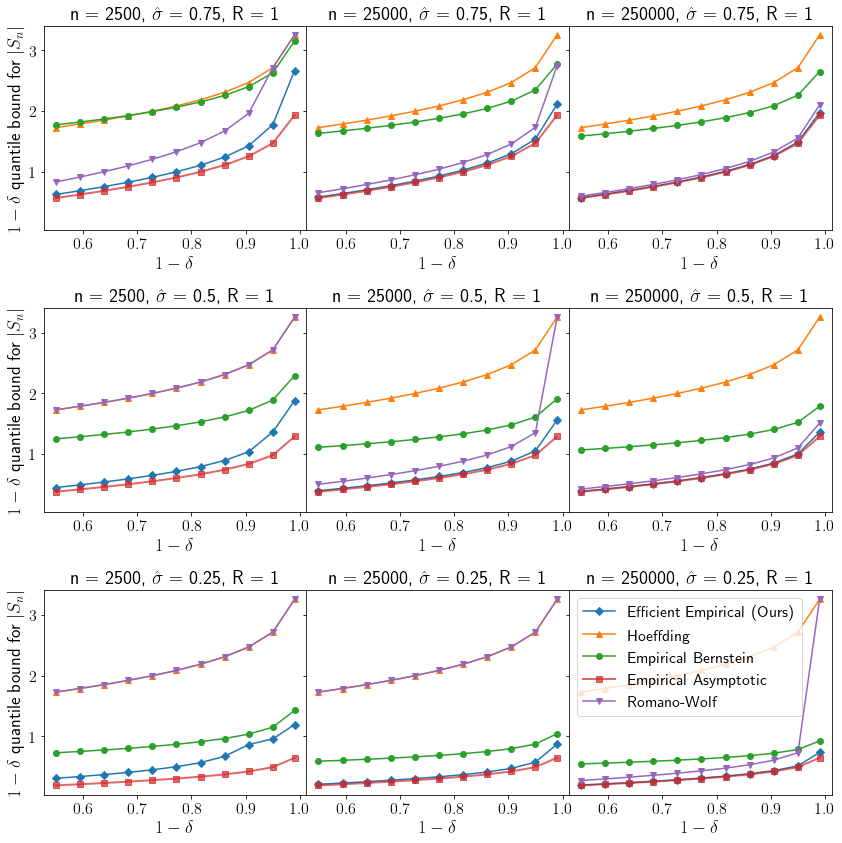

In [16]:
# Plot empirical quantile bounds
ns = 25 * (np.power(10, range(2,5)))
R = 1 
two_sided = True
sighats = R * [.75, .5, .25]
deltas = np.concatenate(([.01], np.linspace(.05, .45, num=10)))
verbose = False
bounds=['hoeff','eff','rw','bern']
v3_mult=1
v4_mult=0.5
emp_quantile_fig = plot_emp_quantile_bounds(
    deltas, ns, sighats, R, two_sided, verbose=verbose, bounds=bounds, 
    v3_mult=v3_mult, v4_mult=v4_mult)

In [17]:
# Save quantile bounds figure to file
savefig(emp_quantile_fig, f"emp_quantile_bounds-two_sided{two_sided}-v3x{v3_mult}-v4x{v4_mult}.pdf")